# Lesson5 画像からキャプションを生成する
## Section1 解説
### 1.1 キャプション生成とは
**キャプション生成**＝画像を入力としてその画像の説明文(キャプション)を出力するタスク

下図にキャプション生成のイメージを示す。

<img src=figures/cap_gen_image.png>

研究の意義としては、例えば、視覚障害のある人にWeb上にある画像の内容を理解させるために、自動で説明文を生成する、等。

基本的なネットワーク構成としては、画像の特徴量をCNNにより抽出し、その特徴量をもとにRNNで説明文を生成していく。

### 1.2 前Lesson(翻訳モデル)との関係性
全Lessonで学んだ翻訳モデルとの関係性を考える。

翻訳モデルでは、Encoder(RNN)で元言語文の特徴を抽出し、その特徴量をもとにDecoder(RNN)でターゲット言語の文を生成した。

キャプション生成のモデルでも基本的な構造は同じ。CNNで画像の特徴を抽出し、その特徴をもとに説明文を生成する。

翻訳タスクもキャプション生成タスクも、同じ言語生成という広いくくりのタスクとして俯瞰することができる。

違いは、どのようにDecoder側の言語モデルの初期状態(具体的にはRNNであれば最初の隠れ層$h_0$)を条件づけるか、という部分。

問題設定をうまく工夫することで、一口に言語生成といっても要約・対話などさまざまなタスクに対処できるようになる。

問題設定が変わったからと言って大幅にモデルが変わることもない。

具体的には、キャプション生成のモデルの入力情報が画像となるので、EncoderをCNNに変更するだけでよい。

(翻訳モデルでは入力情報が文だったので、系列に特化したRNNを特徴抽出に用いていた。)

後述するAttentionの利用についても、同じように元情報の特徴量に対して適用するという構図が同じ。

翻訳では元文の各隠れ層状態を参考にAttentionを適用していたが、キャプション生成では元画像のCNNの出力の各ピクセルに対して適用していく。

### 1.3 データセット
キャプション生成のタスクにおいてもいくつか代表的なデータセットがあるが、今回はそのうちの1つであるMS-COCOと呼ばれるものを使う。

MS-COCOでは画像に対してキャプションや画像内の物体のラベル等がついている。

日本語に翻訳されたものもある。(https://github.com/STAIR-Lab-CIT/STAIR-captions)

今回は、MS-COCOのキャプションのデータの一部(学習用:50,000ペア、検証用:1,000ペア)を使用する。

まずMS-COCOのデータをdownload/以下にdownloadする。(※時間がかかる)

本来はjupyter notebook上のセルで
```python
!sh download_mscoco.sh
```

としてダウンロードできるが、今回できなかったのでubuntu上で
```
sh download_mscoco.sh
```

としてダウンロードを行った。

次に、画像及びキャプションデータに前処理を施す。(画像サイズの統一、キャプションのtokenize等)(前処理後のデータは/dataいかに保存される。)

In [ ]:
!python preprocess_mscoco.py

中身を少し見てみる。

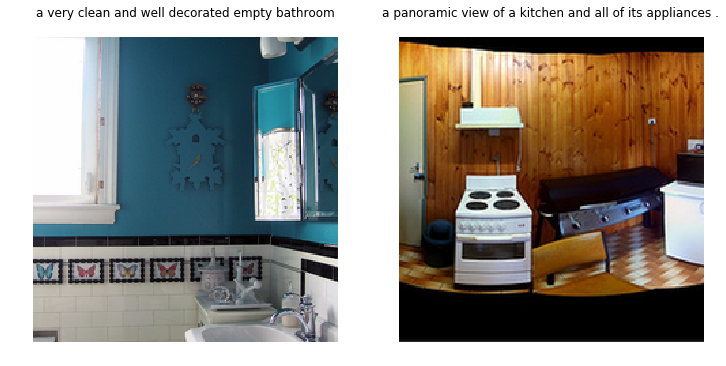

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np

data_y = list(open('./data/y_train.txt'))[:2]
data_x = np.load('./data/x_train.npy')[:2]

plt.figure(figsize=(12, 8))
for i, (x, y) in enumerate(zip(data_x, data_y)):
    plt.subplot(1, 2, i+1)
    plt.imshow(x)
    plt.title(y)
    plt.axis('off')
plt.show()

### 1.4 ネットワーク構成
#### 1.4.1 概要

今回のキャプション生成では、前述したとおり、画像の特徴量の抽出にCNN、説明文の生成にRNNを用いる。

<img src=figures/cap_gen_image.png>

#### 1.4.2 Encoder

CNN(VGGNet)を使用する。ここで、事前に大規模なデータセット(ImageNet)で学習されたモデルの重みを利用(転移)する。(keras.applicationsから読み込み可)

VGG16の引数は、weights、include_top、input_tensorの3つ。
- weights : 重みの種類を指定する。ここではImageNet で学習した重みを使用する。重みを指定せずに自分で重みを学習することも可能だが、学習には大量の画像が必要になるなどのコストがかかる。

- input_top : VGG16の出力層を含むかどうかを決定する。今回はあくまでもEncoderは特徴抽出器として使いたいだけなので含まない。

- inout_tensor : 入力画像のサイズを指定する。

また、今回のモデルの学習時には、このCNNの重みの更新は行わない。学習を容易にする(学習パラメータの数を減らす)ため。

具体的な実装はSection2で行うこととする。


In [2]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input

x = Input(shape=(224,224,3))
model = VGG16(
    weights='imagenet', 
    include_top=False,
    input_tensor=x)

C:\Users\yanor\Anaconda3\envs\matsuo\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ネットワーク構成は.summary()で確認できる。

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

#### 1.4.3 Decoder

ここでは翻訳モデルと同様にLSTMを用いる。 LSTMの隠れ層とメモリセルの初期状態$h_0$、$c_0$はEncoder(CNN)の出力を元に決定する。